In [1]:
# this is the wrapper notebook
# 1) it shows how a regression model is created
# 2) how the model input and output and model weights get quantized
# 3) how the model weights and test set are exported as cairo inputs
# 4) how cairo script is invoked
# 5) how cairo proof is generated
# 7) how cairo prediction output is retrieved
# 8) cairo prediction output is dequantized
# 9) cairo prediction and native prediction is compared

In [2]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression
from sklearn.model_selection import train_test_split
from concrete.ml.quantization import QuantizedArray
import json
from json import JSONEncoder

/home/mister/micromamba/envs/cairo1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

# Create the training and test set

In [4]:
BITS=32
# pylint: disable=unbalanced-tuple-unpacking
WEIGHTS=5
X, y = make_regression(
    n_samples=200, n_features=WEIGHTS, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#sidx = np.argsort(np.squeeze(x_train))
#x_train = x_train[sidx, :]
#y_train = y_train[sidx]

#sidx = np.argsort(np.squeeze(x_test))
#x_test = x_test[sidx, :]
#y_test = y_test[sidx]

In [5]:
linreg = SklearnLinearRegression()
tic = time.perf_counter()
linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"Classic sklearn fitting {toc - tic:0.4f} seconds")
print(linreg.coef_)

Classic sklearn fitting 0.0077 seconds
[ 1.63586268 11.4331783  67.09072934 19.66672525 65.61296023]


In [6]:
tic = time.perf_counter()
y_pred = linreg.predict(x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Classic sklearn model prediction 0.0006 seconds


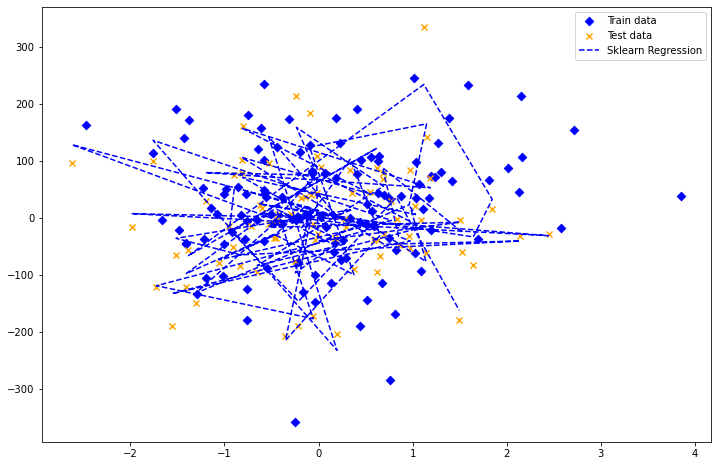

In [7]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train[:,0], y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test[:,0], y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test[:,0], y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


#  how the model input and output and model weights get quantized
Open point: How to get the coefficient and intercept quantized? Somehow it should be possible to extract it from concrete ml?

In [8]:
q_X = QuantizedArray(BITS, X)
q_y = QuantizedArray(BITS, y)
# Split it into train/test and sort the sets for nicer visualization
q_x_train, q_x_test, q_y_train, q_y_test = train_test_split(q_X.quant(), q_y.quant(), test_size=0.4, random_state=42)

#q_sidx = np.argsort(np.squeeze(q_x_train))
#q_x_train = q_x_train[sidx, :]
#q_y_train = q_y_train[sidx]#

#q_sidx = np.argsort(np.squeeze(q_x_test))
#q_x_test = q_x_test[q_sidx, :]
#q_y_test = q_y_test[sidx]

In [9]:
linreg_qdata = SklearnLinearRegression()
tic = time.perf_counter()
linreg_qdata.fit(q_x_train, q_y_train)
toc = time.perf_counter()
print(f"Quantized data sklearn fitting {toc - tic:0.4f} seconds")
print(linreg_qdata.coef_)

Quantized data sklearn fitting 0.0041 seconds
[0.01673408 0.11695589 0.68630573 0.20118109 0.67118886]


In [10]:
tic = time.perf_counter()
q_y_pred = linreg_qdata.predict(q_x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Quantized data sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Quantized data sklearn model prediction 0.0004 seconds


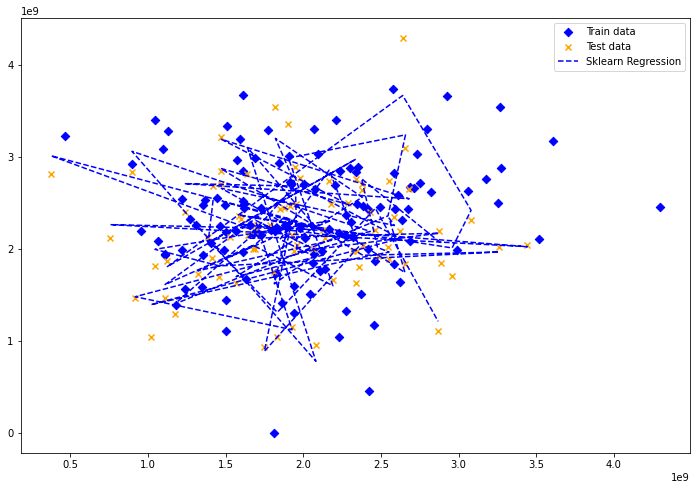

In [11]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(q_x_train[:,0], q_y_train, c="blue", marker="D", label="Train data")
ax.scatter(q_x_test[:,0], q_y_test, c="orange", marker="x", label="Test data")
ax.plot(q_x_test[:,0], q_y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


In [12]:
q_linreg = ConcreteLinearRegression(n_bits={"inputs": BITS, "weights": WEIGHTS})
tic = time.perf_counter()
q_linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc - tic:0.4f} seconds")

FHE sklearn model fit 0.1252 seconds


In [13]:
q_linreg.coef_

array([ 1.63586268, 11.4331783 , 67.09072934, 19.66672525, 65.61296023])

In [37]:
np.concatenate([[q_linreg.intercept_], q_linreg.coef_])

array([ 8.04687001,  1.63586268, 11.4331783 , 67.09072934, 19.66672525,
       65.61296023])

In [28]:
np.round(q_linreg.coef_)

array([ 2., 11., 67., 20., 66.])

In [19]:
q_linreg.quantized_module.quantize_input(x_test).astype(int).tolist()

[[2884537452, 2858394733, 2009223839, 1957555296, 1440929155],
 [2375224364, 1640974784, 1666057621, 3492279874, 2594555550],
 [2478476658, 736286566, 2075268512, 2346180072, 1561712408],
 [2552755507, 1419151494, 2008277088, 1954967580, 1552403669],
 [2338159897, 1522146688, 1812525358, 1011710542, 1917317496],
 [1019941784, 2597490918, 1535946701, 1645906522, 1109648056],
 [2624845936, 1363239142, 1886226207, 1652873490, 1996120133],
 [1980397685, 1938434084, 2374987764, 2599999622, 1979527210],
 [1110737963, 2075457681, 1505045671, 1522990281, 1592146901],
 [1676657351, 831871336, 2377869336, 3363761488, 985984839],
 [2190813794, 1798990034, 1369802745, 1653599577, 1693390777],
 [1904686813, 2095063879, 2113368262, 1776041985, 2917430346],
 [2658194485, 2036251446, 3512351380, 1613869956, 1904224037],
 [2545645498, 2438912137, 2663838519, 1372274165, 1465511025],
 [1172608507, 1942587625, 710676888, 2194909547, 1908425683],
 [1699322261, 1649949805, 2020577273, 2530453684, 168250379

# how the model weights and test set are exported as cairo inputs

In [39]:
json_data = {}
json_data["intercept"] = np.round(q_linreg.intercept_)
json_data["weights"] =np.round(q_linreg.coef_).astype(int).tolist()
json_data["X"] = q_linreg.quantized_module.quantize_input(x_test).tolist()

In [40]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [41]:

with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4, cls=NumpyArrayEncoder)

In [24]:
q_linreg.quantized_module.dequantize_output([306081844330])

array([36398.27118553])